In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.models as models
import torchvision.transforms as T

from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader,Subset,Dataset,random_split
from PIL import Image


import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
from sklearn.metrics import classification_report, confusion_matrix

from torch.utils.data import Dataset
import pandas as pd
import torch.optim as optim
from torch.utils.data import DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
import copy

In [4]:
color_map = {'Black': 0, 'Blue': 1, 'Brown': 2, 'Green': 3, 'Gray': 4, 'Orange': 5, 'Pink': 6, 'Purple': 7, 'Red': 8, 'White': 9, 'Yellow': 10}
type_map = {'top': 0, 'bottom': 1}

In [5]:
class Dataset(Dataset):
    def __init__(self, csv_path, image_dir="image", spec_dir="mel",
                 transform_image=None, transform_spec=None):
        self.df = pd.read_csv(csv_path)
        self.image_dir = image_dir
        self.spec_dir = spec_dir
        self.transform_image = transform_image
        self.transform_spec = transform_spec

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        image_path = os.path.join(self.image_dir, row['image_name'])
        if not os.path.exists(image_path):
            raise FileNotFoundError(f"Image not found: {image_path}")
        image = Image.open(image_path).convert('RGB')
        if self.transform_image:
            image = self.transform_image(image)

        spec_path = os.path.join(self.spec_dir, row['audio_file'].replace('.wav', '.npy'))
        if not os.path.exists(spec_path):
            raise FileNotFoundError(f"Spec not found: {spec_path}")
        spec = np.load(spec_path)
        audio = torch.tensor(spec, dtype=torch.float32)
        if audio.ndim == 2:
            audio = audio.unsqueeze(0) 
        if self.transform_spec:
            if isinstance(audio, torch.Tensor):
                audio = audio.expand(3, -1, -1)  
                audio = audio.mean(dim=0, keepdim=True) 
            else:
                raise TypeError("audio must be torch.Tensor before applying transform_spec")
        
        labels = {
            'condition': torch.tensor(int(row['condition']), dtype=torch.long),
            'color': torch.tensor(color_map[row['color']], dtype=torch.long),
            'smell': torch.tensor(1 if str(row['smell']).lower() in ['true', '1'] else 0, dtype=torch.long),
            'pilling': torch.tensor(int(row['pilling']), dtype=torch.long),
            'type': torch.tensor(type_map[row['type']], dtype=torch.long)
        }

        return {
            'image': image,
            'audio': audio,
            'labels': labels
        }

In [6]:
transform_image = T.Compose([
    T.Resize((256, 256)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(degrees=15),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    T.RandomResizedCrop((224, 224), scale=(0.8, 1.0)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

transform_spec = T.Compose([
    T.Resize((128, 128)),
    T.RandomApply([T.RandomAffine(degrees=0, translate=(0.1, 0.1))], p=0.3),
    T.RandomErasing(scale=(0.02, 0.15), ratio=(0.3, 3.3), value=0.0, p=0.2),
    T.ToTensor(),
    T.Normalize(mean=[0.5], std=[0.5])
])

train_dataset = Dataset(
    csv_path='train_paired.csv',
    image_dir='dataset/dataset/image',
    spec_dir='dataset/dataset/mel',
    transform_image=transform_image,
    transform_spec=transform_spec
)

val_dataset = Dataset(
    csv_path='val_paired.csv',
    image_dir='dataset/dataset/image',
    spec_dir='dataset/dataset/mel',
    transform_image=transform_image,
    transform_spec=transform_spec
)


In [7]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [8]:
class ImageEncoder(nn.Module):
    def __init__(self, output_dim=128):
        super(ImageEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.MaxPool2d(2),

            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(128, output_dim)

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        return self.fc(x)

class AudioEncoder(nn.Module):
    def __init__(self, input_dim=64, hidden_dim=128, output_dim=128):
        super(AudioEncoder, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim * 2, output_dim) 

    def forward(self, x):
        if x.dim() == 4:
            x = x.squeeze(1)
        x = x.permute(0, 2, 1)
        out, _ = self.lstm(x)
        last_timestep = out[:, -1, :]
        last_timestep = self.dropout(last_timestep)
        return self.fc(last_timestep)


In [9]:
class MulitTaskModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.image_encoder = ImageEncoder(output_dim=128)
        self.audio_encoder = AudioEncoder(input_dim=64, output_dim=128)

        self.shared_fc = nn.Sequential(
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.5)
        )

        self.head_condition = nn.Linear(128, 5)
        self.head_color = nn.Linear(128, 11)
        self.head_smell = nn.Linear(128, 2)
        self.head_pilling = nn.Linear(128, 5)
        self.head_type = nn.Linear(128, 2)

    def forward(self, image, audio, return_fusion=False):
        img_features = self.image_encoder(image)
        audio_features = self.audio_encoder(audio)
        x = torch.cat((img_features, audio_features), dim=1)
        fusion = self.shared_fc(x)

        if return_fusion:
            return fusion 

        return {
            'condition': self.head_condition(fusion),
            'color': self.head_color(fusion),
            'smell': self.head_smell(fusion),
            'pilling': self.head_pilling(fusion),
            'type': self.head_type(fusion)
        }


In [10]:
loss_fn_condition = nn.CrossEntropyLoss()
loss_fn_pilling   = nn.CrossEntropyLoss()
loss_fn_color     = nn.CrossEntropyLoss()
loss_fn_smell     = nn.CrossEntropyLoss()  
loss_fn_type      = nn.CrossEntropyLoss()  

def compute_loss(preds, targets):
    return (
        1.5 * loss_fn_condition(preds['condition'], targets['condition']-1) +
        1.2 * loss_fn_pilling(preds['pilling'], targets['pilling']-1) +
        loss_fn_smell(preds['smell'], targets['smell']) +
        loss_fn_color(preds['color'], targets['color']) +
        loss_fn_type(preds['type'], targets['type'])
    )

In [11]:
from sklearn.metrics import accuracy_score

def compute_accuracy(preds, targets, task_names):
    acc = {}
    for task in task_names:
        pred_labels = preds[task].argmax(dim=1)
        true_labels = targets[task]
        correct = (pred_labels == true_labels).sum().item()
        total = true_labels.size(0)
        acc[task] = 100.0 * correct / total
    return acc

In [13]:
def train_model(model, train_loader, val_loader, optimizer, device, task_names,
                num_epochs=10, patience=10, save_path='best_model.pth'):
    best_loss = float('inf')
    best_model = copy.deepcopy(model.state_dict())
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_total_acc = {task: 0.0 for task in task_names}
        num_train_batches = 0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images = batch['image'].to(device)
            audio = batch['audio'].to(device)
            labels = {task: batch['labels'][task].to(device) for task in task_names}

            optimizer.zero_grad()
            preds = model(images, audio)
            loss = compute_loss(preds, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            acc = compute_accuracy(preds, labels, task_names)
            for task in task_names:
                train_total_acc[task] += acc[task]
            num_train_batches += 1

        train_loss /= len(train_loader)
        train_avg_acc = {task: train_total_acc[task] / num_train_batches for task in task_names}

        # ---- Validation Phase ----
        model.eval()
        val_loss = 0.0
        val_total_acc = {task: 0.0 for task in task_names}
        num_val_batches = 0

        with torch.no_grad():
            for batch in val_loader:
                images = batch['image'].to(device)
                audio = batch['audio'].to(device)
                labels = {task: batch['labels'][task].to(device) for task in task_names}

                preds = model(images, audio)
                loss = compute_loss(preds, labels)
                val_loss += loss.item()

                acc = compute_accuracy(preds, labels, task_names)
                for task in task_names:
                    val_total_acc[task] += acc[task]
                num_val_batches += 1

        val_loss /= len(val_loader)
        val_avg_acc = {task: val_total_acc[task] / num_val_batches for task in task_names}

        # ---- Logging ----
        print(f"\nEpoch {epoch+1}:")
        print(f"  Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        for task in task_names:
            print(f"  {task:<10} Acc → Train: {train_avg_acc[task]:5.2f}%, Val: {val_avg_acc[task]:5.2f}%")

        # ---- Early stopping ----
        if val_loss < best_loss:
            best_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), save_path)
            print(f"  ✅ Model saved to {save_path}")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("  🛑 Early stopping triggered")
                break

    return model

In [ ]:
model = MulitTaskModel().to(device)
model.load_state_dict(torch.load('best_model3.pth'))  # โหลดโมเดลเดิม


# เปลี่ยน optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=3e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2
)

# เทรนต่อ
trained_model = train_model(
    model, train_loader, val_loader, optimizer,
    device=device, num_epochs=50, patience=7,
    save_path='best_model3.pth',task_names=['condition', 'color', 'smell', 'pilling', 'type']
)

Epoch 1/50: 100%|██████████| 55/55 [04:54<00:00,  5.36s/it]



Epoch 1:
  Train Loss: 6.5759, Val Loss: 6.3553
  condition  Acc → Train: 20.97%, Val: 20.83%
  color      Acc → Train: 57.27%, Val: 63.24%
  smell      Acc → Train: 62.16%, Val: 65.70%
  pilling    Acc → Train: 25.91%, Val: 26.12%
  type       Acc → Train: 74.94%, Val: 75.30%
  ✅ Model saved to best_model3.pth


Epoch 2/50: 100%|██████████| 55/55 [06:01<00:00,  6.56s/it]



Epoch 2:
  Train Loss: 6.4778, Val Loss: 6.1906
  condition  Acc → Train: 20.85%, Val: 19.05%
  color      Acc → Train: 60.51%, Val: 62.95%
  smell      Acc → Train: 62.67%, Val: 65.92%
  pilling    Acc → Train: 26.14%, Val: 26.34%
  type       Acc → Train: 75.23%, Val: 75.30%
  ✅ Model saved to best_model3.pth


Epoch 3/50: 100%|██████████| 55/55 [06:19<00:00,  6.90s/it]



Epoch 3:
  Train Loss: 6.4214, Val Loss: 6.1677
  condition  Acc → Train: 20.28%, Val: 20.54%
  color      Acc → Train: 60.74%, Val: 65.03%
  smell      Acc → Train: 62.56%, Val: 65.25%
  pilling    Acc → Train: 26.19%, Val: 25.45%
  type       Acc → Train: 75.40%, Val: 75.30%
  ✅ Model saved to best_model3.pth


Epoch 4/50: 100%|██████████| 55/55 [05:13<00:00,  5.70s/it]



Epoch 4:
  Train Loss: 6.3982, Val Loss: 6.1684
  condition  Acc → Train: 18.92%, Val: 20.76%
  color      Acc → Train: 60.06%, Val: 63.47%
  smell      Acc → Train: 61.99%, Val: 65.92%
  pilling    Acc → Train: 26.14%, Val: 26.34%
  type       Acc → Train: 75.28%, Val: 75.30%


Epoch 5/50: 100%|██████████| 55/55 [05:16<00:00,  5.76s/it]



Epoch 5:
  Train Loss: 6.3445, Val Loss: 6.1052
  condition  Acc → Train: 20.17%, Val: 20.39%
  color      Acc → Train: 60.57%, Val: 64.88%
  smell      Acc → Train: 63.18%, Val: 65.25%
  pilling    Acc → Train: 26.65%, Val: 26.34%
  type       Acc → Train: 75.34%, Val: 72.47%
  ✅ Model saved to best_model3.pth


Epoch 6/50: 100%|██████████| 55/55 [05:23<00:00,  5.88s/it]



Epoch 6:
  Train Loss: 6.3472, Val Loss: 6.0280
  condition  Acc → Train: 21.14%, Val: 20.16%
  color      Acc → Train: 61.53%, Val: 68.08%
  smell      Acc → Train: 62.39%, Val: 65.92%
  pilling    Acc → Train: 25.80%, Val: 26.34%
  type       Acc → Train: 74.77%, Val: 75.30%
  ✅ Model saved to best_model3.pth


Epoch 7/50: 100%|██████████| 55/55 [06:12<00:00,  6.78s/it]



Epoch 7:
  Train Loss: 6.2788, Val Loss: 6.0567
  condition  Acc → Train: 21.08%, Val: 20.16%
  color      Acc → Train: 62.67%, Val: 65.55%
  smell      Acc → Train: 61.99%, Val: 65.92%
  pilling    Acc → Train: 26.31%, Val: 26.34%
  type       Acc → Train: 75.40%, Val: 75.30%


Epoch 8/50: 100%|██████████| 55/55 [05:17<00:00,  5.78s/it]



Epoch 8:
  Train Loss: 6.2891, Val Loss: 5.9751
  condition  Acc → Train: 20.80%, Val: 20.39%
  color      Acc → Train: 61.99%, Val: 68.90%
  smell      Acc → Train: 62.33%, Val: 66.15%
  pilling    Acc → Train: 26.19%, Val: 26.34%
  type       Acc → Train: 75.57%, Val: 75.30%
  ✅ Model saved to best_model3.pth


Epoch 9/50: 100%|██████████| 55/55 [05:17<00:00,  5.77s/it]



Epoch 9:
  Train Loss: 6.2727, Val Loss: 6.0768
  condition  Acc → Train: 21.31%, Val: 20.09%
  color      Acc → Train: 62.61%, Val: 63.69%
  smell      Acc → Train: 62.56%, Val: 65.70%
  pilling    Acc → Train: 26.02%, Val: 26.34%
  type       Acc → Train: 75.34%, Val: 75.30%


Epoch 10/50: 100%|██████████| 55/55 [05:18<00:00,  5.79s/it]



Epoch 10:
  Train Loss: 6.2597, Val Loss: 6.2465
  condition  Acc → Train: 21.53%, Val: 20.76%
  color      Acc → Train: 63.58%, Val: 61.46%
  smell      Acc → Train: 63.18%, Val: 65.92%
  pilling    Acc → Train: 26.25%, Val: 26.04%
  type       Acc → Train: 75.40%, Val: 75.30%


Epoch 11/50: 100%|██████████| 55/55 [05:11<00:00,  5.67s/it]



Epoch 11:
  Train Loss: 6.2399, Val Loss: 5.9688
  condition  Acc → Train: 21.53%, Val: 21.65%
  color      Acc → Train: 63.52%, Val: 67.11%
  smell      Acc → Train: 62.56%, Val: 65.92%
  pilling    Acc → Train: 26.19%, Val: 26.34%
  type       Acc → Train: 75.06%, Val: 75.30%
  ✅ Model saved to best_model3.pth


Epoch 12/50: 100%|██████████| 55/55 [05:09<00:00,  5.62s/it]



Epoch 12:
  Train Loss: 6.1975, Val Loss: 6.0992
  condition  Acc → Train: 22.90%, Val: 20.83%
  color      Acc → Train: 63.35%, Val: 63.24%
  smell      Acc → Train: 62.73%, Val: 65.92%
  pilling    Acc → Train: 25.80%, Val: 26.34%
  type       Acc → Train: 75.17%, Val: 75.30%


Epoch 13/50: 100%|██████████| 55/55 [05:06<00:00,  5.58s/it]



Epoch 13:
  Train Loss: 6.1377, Val Loss: 5.9485
  condition  Acc → Train: 23.18%, Val: 22.77%
  color      Acc → Train: 65.06%, Val: 67.49%
  smell      Acc → Train: 62.56%, Val: 66.15%
  pilling    Acc → Train: 25.80%, Val: 26.34%
  type       Acc → Train: 75.28%, Val: 75.30%
  ✅ Model saved to best_model3.pth


Epoch 14/50: 100%|██████████| 55/55 [05:10<00:00,  5.65s/it]



Epoch 14:
  Train Loss: 6.1622, Val Loss: 5.9140
  condition  Acc → Train: 23.01%, Val: 21.50%
  color      Acc → Train: 64.43%, Val: 69.64%
  smell      Acc → Train: 62.27%, Val: 65.92%
  pilling    Acc → Train: 26.02%, Val: 26.34%
  type       Acc → Train: 75.06%, Val: 75.30%
  ✅ Model saved to best_model3.pth


Epoch 15/50: 100%|██████████| 55/55 [05:16<00:00,  5.76s/it]



Epoch 15:
  Train Loss: 6.1363, Val Loss: 5.9792
  condition  Acc → Train: 21.42%, Val: 21.50%
  color      Acc → Train: 65.68%, Val: 67.11%
  smell      Acc → Train: 62.39%, Val: 64.81%
  pilling    Acc → Train: 25.06%, Val: 26.34%
  type       Acc → Train: 75.23%, Val: 75.30%


Epoch 16/50: 100%|██████████| 55/55 [05:16<00:00,  5.76s/it]



Epoch 16:
  Train Loss: 6.1757, Val Loss: 6.5143
  condition  Acc → Train: 22.95%, Val: 29.24%
  color      Acc → Train: 64.55%, Val: 50.97%
  smell      Acc → Train: 61.88%, Val: 65.92%
  pilling    Acc → Train: 26.08%, Val: 26.34%
  type       Acc → Train: 75.62%, Val: 75.30%


Epoch 17/50: 100%|██████████| 55/55 [05:16<00:00,  5.76s/it]



Epoch 17:
  Train Loss: 6.1698, Val Loss: 6.0092
  condition  Acc → Train: 21.53%, Val: 28.57%
  color      Acc → Train: 65.23%, Val: 70.31%
  smell      Acc → Train: 61.53%, Val: 65.92%
  pilling    Acc → Train: 26.19%, Val: 24.85%
  type       Acc → Train: 75.23%, Val: 75.30%


Epoch 18/50: 100%|██████████| 55/55 [05:20<00:00,  5.83s/it]



Epoch 18:
  Train Loss: 6.1541, Val Loss: 5.9372
  condition  Acc → Train: 22.44%, Val: 20.83%
  color      Acc → Train: 64.32%, Val: 68.68%
  smell      Acc → Train: 62.90%, Val: 63.76%
  pilling    Acc → Train: 26.48%, Val: 26.34%
  type       Acc → Train: 75.51%, Val: 75.30%


Epoch 19/50: 100%|██████████| 55/55 [05:17<00:00,  5.78s/it]



Epoch 19:
  Train Loss: 6.1137, Val Loss: 5.9705
  condition  Acc → Train: 21.99%, Val: 20.61%
  color      Acc → Train: 64.26%, Val: 66.89%
  smell      Acc → Train: 61.88%, Val: 65.92%
  pilling    Acc → Train: 25.57%, Val: 26.12%
  type       Acc → Train: 75.23%, Val: 75.30%


Epoch 20/50: 100%|██████████| 55/55 [05:17<00:00,  5.77s/it]



Epoch 20:
  Train Loss: 6.1268, Val Loss: 5.8304
  condition  Acc → Train: 22.10%, Val: 21.43%
  color      Acc → Train: 64.66%, Val: 71.58%
  smell      Acc → Train: 62.33%, Val: 65.10%
  pilling    Acc → Train: 25.91%, Val: 26.34%
  type       Acc → Train: 75.51%, Val: 75.30%
  ✅ Model saved to best_model3.pth


Epoch 21/50: 100%|██████████| 55/55 [06:26<00:00,  7.03s/it]



Epoch 21:
  Train Loss: 6.0704, Val Loss: 6.5535
  condition  Acc → Train: 22.56%, Val: 27.75%
  color      Acc → Train: 66.08%, Val: 47.10%
  smell      Acc → Train: 62.61%, Val: 65.70%
  pilling    Acc → Train: 26.25%, Val: 22.40%
  type       Acc → Train: 75.34%, Val: 75.30%


Epoch 22/50: 100%|██████████| 55/55 [05:35<00:00,  6.10s/it]



Epoch 22:
  Train Loss: 6.0939, Val Loss: 5.7889
  condition  Acc → Train: 21.88%, Val: 22.40%
  color      Acc → Train: 66.59%, Val: 72.25%
  smell      Acc → Train: 62.95%, Val: 65.70%
  pilling    Acc → Train: 26.08%, Val: 25.07%
  type       Acc → Train: 75.34%, Val: 75.30%
  ✅ Model saved to best_model3.pth


Epoch 23/50: 100%|██████████| 55/55 [05:57<00:00,  6.49s/it]



Epoch 23:
  Train Loss: 6.0624, Val Loss: 6.1358
  condition  Acc → Train: 22.22%, Val: 27.38%
  color      Acc → Train: 65.23%, Val: 66.37%
  smell      Acc → Train: 62.44%, Val: 65.92%
  pilling    Acc → Train: 25.57%, Val: 20.39%
  type       Acc → Train: 75.45%, Val: 75.30%


Epoch 24/50: 100%|██████████| 55/55 [08:18<00:00,  9.06s/it]



Epoch 24:
  Train Loss: 6.0509, Val Loss: 5.9206
  condition  Acc → Train: 22.44%, Val: 26.26%
  color      Acc → Train: 66.42%, Val: 69.64%
  smell      Acc → Train: 62.61%, Val: 65.92%
  pilling    Acc → Train: 25.40%, Val: 26.12%
  type       Acc → Train: 75.06%, Val: 75.30%


Epoch 25/50: 100%|██████████| 55/55 [09:50<00:00, 10.74s/it]



Epoch 25:
  Train Loss: 6.0206, Val Loss: 5.7752
  condition  Acc → Train: 22.33%, Val: 21.65%
  color      Acc → Train: 67.05%, Val: 69.57%
  smell      Acc → Train: 62.10%, Val: 65.92%
  pilling    Acc → Train: 25.34%, Val: 26.12%
  type       Acc → Train: 75.97%, Val: 75.30%
  ✅ Model saved to best_model3.pth


Epoch 26/50:  89%|████████▉ | 49/55 [07:00<00:35,  5.88s/it]

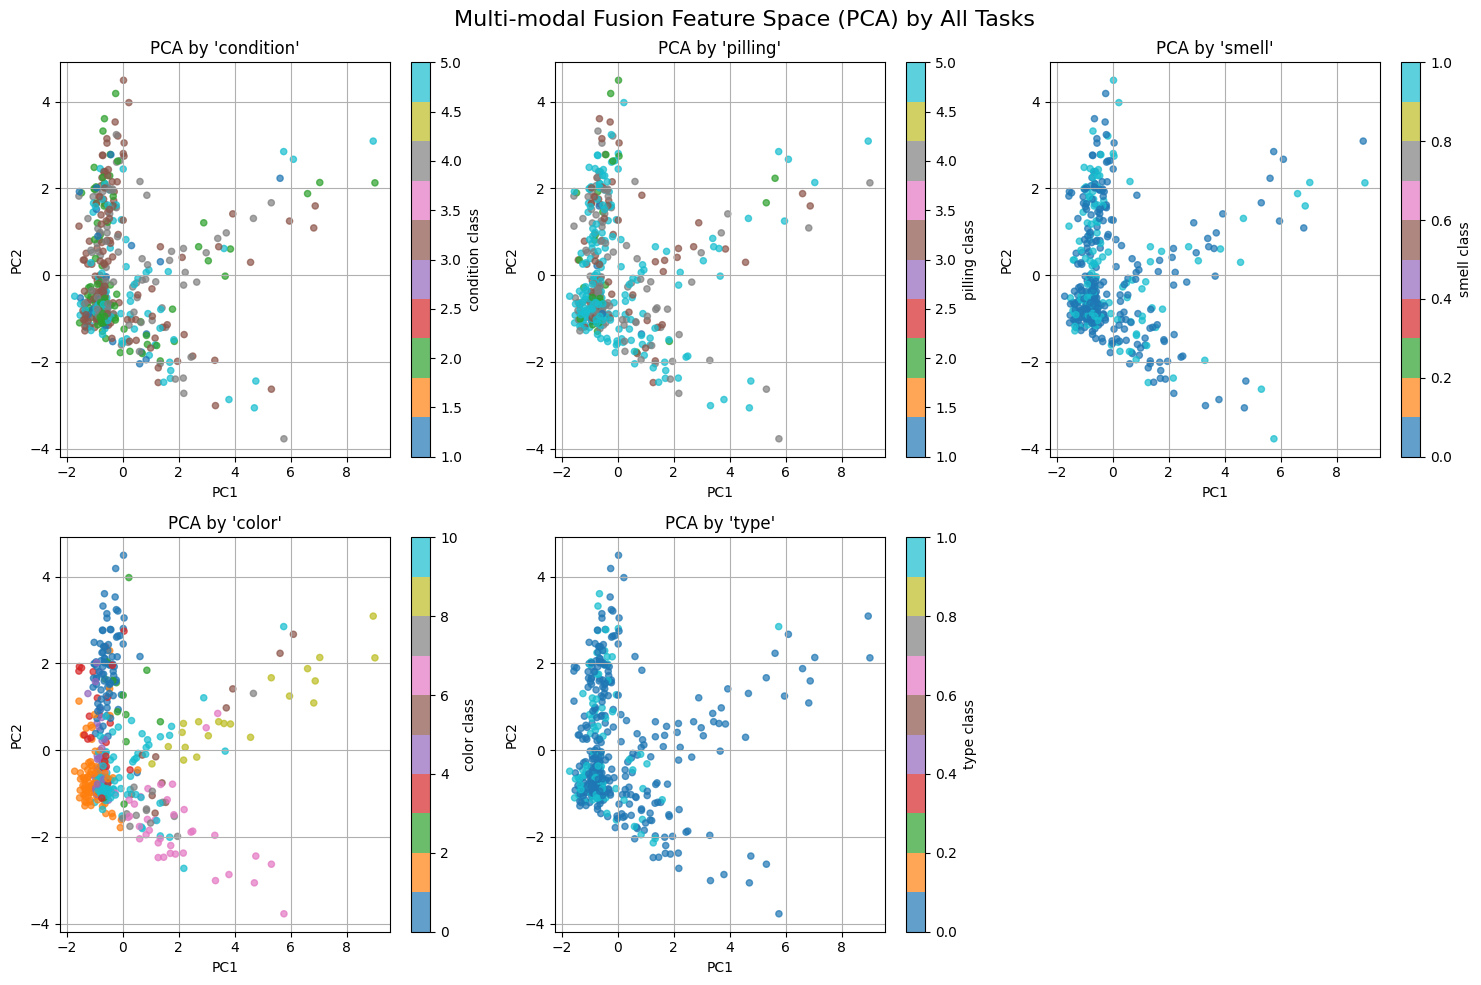

In [14]:
from sklearn.decomposition import PCA

fusion_features = []
labels_per_task = {task: [] for task in ['condition', 'pilling', 'smell', 'color', 'type']}
model = MulitTaskModel().to(device)
model.load_state_dict(torch.load('best_model3.pth'))

model.eval()
with torch.no_grad():
    for batch in val_loader:
        image = batch['image'].to(device)
        audio = batch['audio'].to(device)
        fusion = model(image, audio, return_fusion=True)
        fusion_features.append(fusion.cpu())

        for task in labels_per_task:
            labels_per_task[task].extend(batch['labels'][task].cpu().numpy())

fusion_tensor = torch.cat(fusion_features, dim=0)
fusion_np = fusion_tensor.numpy()

pca = PCA(n_components=2)
fusion_2d = pca.fit_transform(fusion_np)

tasks = list(labels_per_task.keys())
n = len(tasks)
plt.figure(figsize=(15, 10))
for i, task in enumerate(tasks):
    labels = np.array(labels_per_task[task])
    plt.subplot(2, (n + 1) // 2, i + 1)
    scatter = plt.scatter(fusion_2d[:, 0], fusion_2d[:, 1], c=labels, cmap='tab10', alpha=0.7, s=20)
    plt.title(f"PCA by '{task}'")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid(True)
    plt.colorbar(scatter, label=f"{task} class")

plt.suptitle("Multi-modal Fusion Feature Space (PCA) by All Tasks", fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
import os
import shutil
import pandas as pd

# โหลดข้อมูลจากไฟล์ CSV
csv_file = 'dataset/test.csv'
df = pd.read_csv(csv_file)

# กำหนดโฟลเดอร์ปลายทาง
output_dir = 'test'
os.makedirs(output_dir, exist_ok=True)

# สมมติว่าใน test.csv มีคอลัมน์ชื่อ 'filename'
for image_name in df['image_name']:
    if os.path.isfile(image_name):
        dst = os.path.join(output_dir, os.path.basename(image_name))
        shutil.copy(image_name, dst)
        print(f"เซฟรูป {image_name} ไปยัง {dst}")
    else:
        print(f"ไม่พบไฟล์: {image_name}")

ไม่พบไฟล์: 90fcf6ee-81d3-4e12-95c9-c79f90e2380c.jpg
ไม่พบไฟล์: 38540b2c-0f88-47e4-a62c-f1a47e34a9b4.jpg
ไม่พบไฟล์: 321876fe-2a07-472b-b5c3-479cd23f4828.jpg
ไม่พบไฟล์: 83681af2-ae8b-410e-87a5-4e3053d311a3.jpg
ไม่พบไฟล์: 7f824544-2319-4c30-a18b-1ab1b0d053df.jpg
ไม่พบไฟล์: 9ddacdf2-e59c-4b39-85ac-6914eeef75f0.jpg
ไม่พบไฟล์: 6b05afbf-3af1-4d1e-9f71-19ba1a491bf6.jpg
ไม่พบไฟล์: 95f98ea9-215a-4389-b61c-c52f1895b256.jpg
ไม่พบไฟล์: 69648c97-4a64-473a-85a9-1ad5ddccea54.jpg
ไม่พบไฟล์: b7304cbe-d080-41a1-9090-8d54a60d4ad4.jpg
ไม่พบไฟล์: bae38c0f-f73e-44ff-9a0f-fe893b8d562b.jpg
ไม่พบไฟล์: 521a5627-48d3-4a44-9afa-6a49bd048264.jpg
ไม่พบไฟล์: b9854b54-9d75-4c42-a297-044fe85298fe.jpg
ไม่พบไฟล์: f73c9d02-d4d1-4c63-8df7-7a5c7ebf9515.jpg
ไม่พบไฟล์: 96de77ec-3404-423c-9ca3-0fe0c29e95ce.jpg
ไม่พบไฟล์: 7aecee07-8d3e-4563-a471-71b9bbc54e07.jpg
ไม่พบไฟล์: d0be5766-76b7-43a8-be21-d8291907a0f7.jpg
ไม่พบไฟล์: 8baeeaac-a6ff-423e-a175-170b42d4384a.jpg
ไม่พบไฟล์: f0d8861f-e31b-4112-962d-2cb9920cf4ee.jpg
ไม่พบไฟล์: f

In [36]:
import os
import pandas as pd

# โหลดไฟล์ CSV และดึงชื่อรูป
df = pd.read_csv('dataset/dataset/test.csv')
image_names_df = set(df['image_name'])

# ดึงชื่อไฟล์ทั้งหมดในโฟลเดอร์
image_folder = 'dataset/dataset/image'
image_names_folder = set(os.listdir(image_folder))

# ตรวจสอบชื่อที่ตรงกัน
matched_images = image_names_df.intersection(image_names_folder)
print(f"จำนวนภาพที่ตรงกัน: {len(matched_images)}")

จำนวนภาพที่ตรงกัน: 800


In [ ]:
import os
import shutil


# โฟลเดอร์ต้นทางและปลายทาง
source_folder = 'dataset/dataset/image'
destination_folder = 'dataset/dataset/test'
os.makedirs(destination_folder, exist_ok=True)

# คัดลอกไฟล์ที่ตรงกัน
for name in matched_images:
    source_path = os.path.join(source_folder, name)
    dest_path = os.path.join(destination_folder, name)
    if os.path.isfile(source_path):
        shutil.copy2(source_path, dest_path)

print(f"คัดลอกภาพที่ตรงกันเสร็จเรียบร้อย: {len(matched_images)} ไฟล์")

คัดลอกภาพที่ตรงกันเสร็จเรียบร้อย: 800 ไฟล์


In [42]:
import torch

# สร้างโมเดล
model = MulitTaskModel()

# โหลด state dict เข้าสู่โมเดล
state_dict = torch.load('best_model3.pth', map_location=torch.device('cpu'))
model.load_state_dict(state_dict)
model.eval()

MulitTaskModel(
  (image_encoder): ImageEncoder(
    (encoder): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU()
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU()
      (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)


In [49]:
# สร้างโมเดลก่อน
model = MulitTaskModel()

# โหลด state dict แล้วใส่เข้าโมเดล
state_dict = torch.load('best_model3.pth', map_location=torch.device('cpu'))
model.load_state_dict(state_dict)

# ตั้งค่า eval
model.eval()

MulitTaskModel(
  (image_encoder): ImageEncoder(
    (encoder): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU()
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU()
      (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)


In [ ]:
import os
from PIL import Image
from torchvision import transforms as T
import torch
import pandas as pd

model = MulitTaskModel()
state_dict = torch.load('best_model3.pth', map_location=torch.device('cpu'))
model.load_state_dict(state_dict)
model.eval()

# คลาสที่โมเดลสามารถทำนายได้
class_names = ['condition', 'pilling', 'smell', 'color','type'] 

# Transform ที่ใช้
transform_image = T.Compose([
    T.Resize((256, 256)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(degrees=15),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    T.RandomResizedCrop((224, 224), scale=(0.8, 1.0)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

test_folder = 'dataset/dataset/test'
image_files = os.listdir(test_folder)

results = []

for file_name in image_files:
    image_path = os.path.join(test_folder, file_name)
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform_image(image).unsqueeze(0)

    dummy_audio = torch.zeros((1, 64, 64))  

    with torch.no_grad():
        output = model(input_tensor, dummy_audio)

    result = {'image_name': file_name}
    for task, logits in output.items():
        pred_class = torch.argmax(logits, dim=1).item()
        result[task] = pred_class 

    results.append(result)

df_results = pd.DataFrame(results)
df_results.to_csv('test.csv', index=False)

print('✅ ทำนายแบบ multi-task เสร็จแล้วและบันทึก test.csv เรียบร้อย')

✅ ทำนายแบบ multi-task เสร็จแล้วและบันทึก test.csv เรียบร้อยครับ


In [57]:


import pandas as pd
df = pd.read_csv('test.csv')

label_maps = {
    'smell': ['False', 'True'],
    'color': ['Black', 'Blue', 'Brown', 'Green', 'Gray', 'Orange', 'Pink', 'Purple', 'Red', 'White', 'Yellow'],
    'type': ['top', 'bottom']
}

for task, label_list in label_maps.items():
    if task in df.columns:
        df[task] = df[task].apply(lambda i: label_list[int(i)] if pd.notnull(i) else i)

df.to_csv('test_labeled.csv', index=False)

print("✅ แปลง class index เป็น string เรียบร้อย เก็บไว้ในไฟล์ 'test_labeled.csv'")

✅ แปลง class index เป็น string เรียบร้อย เก็บไว้ในไฟล์ 'test_labeled.csv'


In [64]:
import os
import torch
import pandas as pd
from PIL import Image
from torchvision import transforms
from sklearn.metrics import fbeta_score

# ----- เตรียมโมเดล -----
model = MulitTaskModel()
state_dict = torch.load('best_model3.pth', map_location=torch.device('cpu'))
model.load_state_dict(state_dict)
model.eval()

# ----- label mapping สำหรับแปลง index → string -----
label_maps = {
    'smell': ['False', 'True'],
    'color': ['Black', 'Blue', 'Brown', 'Green', 'Gray', 'Orange', 'Pink', 'Purple', 'Red', 'White', 'Yellow'],
    'type': ['top', 'bottom'],
    'pilling': ['1', '2', '3', '4','5'],
    'condition': ['1', '2', '3', '4', '5']
}
tasks = list(label_maps.keys())

ground_truth = pd.read_csv('dataset/dataset/train.csv') 
ground_truth = ground_truth[['image_name'] + tasks]


transform_image = T.Compose([
    T.Resize((256, 256)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(degrees=15),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    T.RandomResizedCrop((224, 224), scale=(0.8, 1.0)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])
test_folder = 'dataset/dataset/image'
image_files = os.listdir(test_folder)

# ----- ทำการทำนาย -----
results = []

for file_name in image_files:
    image_path = os.path.join(test_folder, file_name)
    if not os.path.isfile(image_path):
        continue

    image = Image.open(image_path).convert('RGB')
    input_tensor = transform_image(image).unsqueeze(0)

    dummy_audio = torch.zeros((1, 64, 64))  # ปลอม audio input

    with torch.no_grad():
        output = model(input_tensor, dummy_audio)

    row = {'image_name': file_name}
    for task in tasks:
        pred_idx = torch.argmax(output[task], dim=1).item()
        row[task] = label_maps[task][pred_idx]
    results.append(row)

df_pred = pd.DataFrame(results)

# ----- รวม predicted label กับ ground truth -----
df_merged = pd.merge(ground_truth, df_pred, on='image_name', suffixes=('_true', ''))
print(df_merged.columns.tolist())

['image_name', 'smell_true', 'color_true', 'type_true', 'pilling_true', 'condition_true', 'smell', 'color', 'type', 'pilling', 'condition']


In [68]:
# ----- คำนวณ Weighted F-beta Score -----
task_weights = {
    'condition': (1.5, 0.19),
    'pilling':   (1.5, 0.20),
    'smell':     (2.0, 0.23),
    'color':     (1.0, 0.20),
    'type':      (1.0, 0.18)
}


total_score = 0
print("\n📊 Weighted F-beta Evaluation")
for task, (beta, weight) in task_weights.items():
    y_true_col = f"{task}_true"
    y_pred_col = task

    if y_true_col not in df_merged.columns or y_pred_col not in df_merged.columns:
        print(f"{task}: ⚠️ missing columns {y_true_col} or {y_pred_col}")
        continue

    y_true = df_merged[y_true_col].astype(str)
    y_pred = df_merged[y_pred_col].astype(str)
    classes = sorted(set(y_true) | set(y_pred))  # จัดการเฉพาะ string แล้ว sort ได้ชัวร์

    label_to_int = {label: i for i, label in enumerate(classes)}
    y_true_int = y_true.map(label_to_int)
    y_pred_int = y_pred.map(label_to_int)

    score = fbeta_score(y_true_int, y_pred_int, beta=beta, average='weighted', zero_division=0)
    total_score += weight * score
    print(f"{task}: F{beta} = {score:.4f} (weight {weight})")

print(f"\n🎯 Total Weighted F-beta Score: {total_score:.4f}")


📊 Weighted F-beta Evaluation
condition: F1.5 = 0.2841 (weight 0.19)
pilling: F1.5 = 0.3491 (weight 0.2)
smell: F2.0 = 0.5729 (weight 0.23)
color: F1.0 = 0.6643 (weight 0.2)
type: F1.0 = 0.6490 (weight 0.18)

🎯 Total Weighted F-beta Score: 0.5052


In [69]:
import pandas as pd

# โหลดไฟล์ผลลัพธ์
df = pd.read_csv('test_labeled.csv')

# จัดลำดับคอลัมน์ใหม่
ordered_columns = ['image_name', 'condition', 'pilling', 'smell', 'color', 'type']
df = df[ordered_columns]

# บันทึกไฟล์ใหม่
df.to_csv('test_labeled_reordered.csv', index=False)

print("✅ จัดเรียงคอลัมน์ใหม่และเซฟเป็น 'test_labeled_reordered.csv' เรียบร้อยครับ")

✅ จัดเรียงคอลัมน์ใหม่และเซฟเป็น 'test_labeled_reordered.csv' เรียบร้อยครับ
